# 量子近似优化算法 (QAOA)

## 概述

QAOA 是一种混合经典量子算法，它结合了量子电路与经典优化。
在本教程中，我们利用 QAOA 解决最大割 (MAX CUT) 组合优化问题：给定一个图 $G=(V, E)$，其中节点 $V$ 和边 $E$，找到一个子集 $S \in V$ 使得 $S$ 和 $S \backslash V$ 之间的边数最大化。
这个问题可以简化为寻找反铁磁伊辛模型的基态，其哈密顿量为：

$$H_C = \frac{1}{2} \sum_{i,j\in E} C_{ij} \sigma^{z}_{i} \sigma^{z}_{j},$$

其中 $\sigma^{z}_{i}$ 是第 $i$ 个量子比特上的 Pauli-z 矩阵，$C_{ij}$ 是节点 $i$ 和 $j$ 之间的边的权重。
为简单起见，我们设置 $C_{ij}=1$。如果 $\sigma^{z}_{i}=\sigma^{z}_{j}$, $i,j\in S$ 或 $i,j\in S \backslash V$；
如果 $\sigma^{z}_{i}= -\sigma^{z}_{j}$, $i\in S, j\in S \backslash V$ 或 $i\in S \backslash V，j\ 。
显然，$S $ 和 S\backslash V$ 之间的边数在从基态解码的图结构中最大化。

## 设置

In [1]:
import tensorcircuit as tc
import tensorflow as tf
import networkx as nx

K = tc.set_backend("tensorflow")

nlayers = 3  # 层数
ncircuits = 2  # 有不同初始参数的电路数量

## 定义图

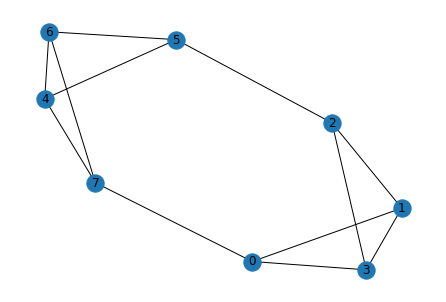

In [2]:
def dict2graph(d):
    g = nx.to_networkx_graph(d)
    for e in g.edges:
        if not g[e[0]][e[1]].get("weight"):
            g[e[0]][e[1]]["weight"] = 1.0
    nx.draw(g, with_labels=True)
    return g


# 一个图实例
# 每个节点连接三个节点
# 例如，节点 0 连接到节点 1,7,3
example_graph_dict = {
    0: {1: {"weight": 1.0}, 7: {"weight": 1.0}, 3: {"weight": 1.0}},
    1: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 3: {"weight": 1.0}},
    2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 5: {"weight": 1.0}},
    4: {7: {"weight": 1.0}, 6: {"weight": 1.0}, 5: {"weight": 1.0}},
    7: {4: {"weight": 1.0}, 6: {"weight": 1.0}, 0: {"weight": 1.0}},
    3: {1: {"weight": 1.0}, 2: {"weight": 1.0}, 0: {"weight": 1.0}},
    6: {7: {"weight": 1.0}, 4: {"weight": 1.0}, 5: {"weight": 1.0}},
    5: {6: {"weight": 1.0}, 4: {"weight": 1.0}, 2: {"weight": 1.0}},
}

example_graph = dict2graph(example_graph_dict)

## 参数化量子电路 (PQC)

具有 $p$ 层的 PQC 可以写成：

$$U(\vec{\beta}, \vec{\gamma}) = V_{p}U_{p} \cdots V_{1}U_{1},$$

其中 $U_{j}= e^{-i\gamma_{j}H_{C}}$ 和 $V_{j}= e^{-i \beta_{j} \sum_{k} \sigma^{x }_{k}}$ 

In [3]:
def QAOAansatz(params, g=example_graph):
    n = len(g.nodes)  # 节点数
    c = tc.Circuit(n)
    for i in range(n):
        c.H(i)
    # PQC
    for j in range(nlayers):
        # U_j
        for e in g.edges:
            c.exp1(
                e[0],
                e[1],
                unitary=tc.gates._zz_matrix,
                theta=g[e[0]][e[1]].get("weight", 1.0) * params[2 * j],
            )
        # V_j
        for i in range(n):
            c.rx(i, theta=params[2 * j + 1])

    # 计算损失函数
    loss = 0.0
    for e in g.edges:
        loss += c.expectation_ps(z=[e[0], e[1]])

    return K.real(loss)

## 主优化循环

In [4]:
# 使用 vvag 获取不同随机电路实例的损失和梯度
QAOA_vvag = K.jit(tc.backend.vvag(QAOAansatz, argnums=0, vectorized_argnums=0))

In [5]:
params = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # 初始参数
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

for i in range(50):
    loss, grads = QAOA_vvag(params, example_graph)
    print(K.numpy(loss))
    params = opt.update(grads, params)  # 梯度下降

[-0.23837963 -1.1651934 ]
[-0.5175445 -1.4539642]
[-0.7306818 -1.6646069]
[-0.91530037 -1.8384367 ]
[-1.0832287 -1.9884492]
[-1.2398103 -2.120449 ]
[-1.3878661 -2.2374902]
[-1.5290209 -2.341291 ]
[-1.6642232 -2.4328852]
[-1.7940071 -2.5128942]
[-1.9186544 -2.5888019]
[-2.0382538 -2.6627793]
[-2.152771 -2.735217]
[-2.2620971 -2.8060198]
[-2.3657765 -2.8749723]
[-2.4635859 -2.942443 ]
[-2.5571456 -3.0074604]
[-2.6474872 -3.071116 ]
[-2.7343643 -3.1320357]
[-2.8174913 -3.1904984]
[-2.896546  -3.2464304]
[-2.971222 -3.298626]
[-3.0411685 -3.3485155]
[-3.1060221 -3.3945203]
[-3.1671162 -3.4365993]
[-3.2244647 -3.47741  ]
[-3.2800133 -3.51378  ]
[-3.328074  -3.5467668]
[-3.3779154 -3.5716858]
[-3.42378   -3.6026983]
[-3.4665916 -3.6264663]
[-3.5065007 -3.6452012]
[-3.5436964 -3.6676104]
[-3.5783873 -3.6827888]
[-3.6107998 -3.696251 ]
[-3.6411772 -3.710956 ]
[-3.6697989 -3.725151 ]
[-3.6969085 -3.739223 ]
[-3.7227716 -3.753837 ]
[-3.747642  -3.7637105]
[-3.7717733 -3.7778597]
[-3.7953677 -3.7